In [63]:
%matplotlib notebook
import scipy.optimize as opt


# make the screen bigger!
from IPython.display import display, HTML
display(HTML(data=""" <style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 85%; }
    div#maintoolbar-container { width: 99%; } </style> """))

# modflow model as a class

In [66]:
import numpy as np
import flopy
import flopy.utils.binaryfile as bf
import matplotlib.pyplot as plt


class Fin_Mod:
    """
    modflow model for multiple well pumping
    every values are represented as 2D np array
    """
    def __init__(self):


        # Assign name and create modflow model object
        txtname = 'test_no_5.2'
        self.model_name = flopy.modflow.Modflow(txtname, exe_name='mf2005')
        self.txtname = txtname

        dis = flopy.modflow.ModflowDis.load('TutCoast_simple5.dis', self.model_name)       # this command is neededed to load an existing .dis file   (essentially is grid geometry)
        bas = flopy.modflow.ModflowBas.load('TutCoast_simple5.ba6',self.model_name)        #  load an existing .basic package                         (essentially is ibound and starting heads)
        lpf = flopy.modflow.ModflowLpf.load('TutCoast_simple5.lpf', self.model_name)       #  load an existing .lpf file    
        rch = flopy.modflow.ModflowRch.load('TutCoast_simple5.rch', self.model_name)       # load recharge
        hobs = flopy.modflow.ModflowHob.load('TutCoast_simple5.hob', self.model_name)      #  LOad OBS
        

        # Add PCG package to the MODFLOW model
        pcg = flopy.modflow.ModflowPcg(self.model_name)
        
        # Add OC package to the MODFLOW model
        spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
        oc = flopy.modflow.ModflowOc(self.model_name, stress_period_data=spd, compact=True)
  
     

    def run(self, All_Qs):
        
        # yay here is where we can mess with the well pump rates (this changes all of them at once)
        wel = flopy.modflow.ModflowWel.load('TutCoast_simple5.wel', self.model_name)
                  
        for idx, i in enumerate(wel.stress_period_data[1]):
            wel.stress_period_data[1][idx][3] = All_Qs 
            
                # MODFLOW input
        # Write the MODFLOW model input files
        # If we cannot (over)write input files, try to write until it succeeds
        while True:
            try:
                self.model_name.write_input()
            except OSError as err:
                print("File writing error: %s" % (err))
            else:  # if we succeed, get out of the loop
                break

        # Run the MODFLOW model
        success, buff = self.model_name.run_model(silent=True)

        return success

    
    def head(self):
        """
            minimum head value
        """

        hds = bf.HeadFile(self.txtname + '.hds')
        times = hds.get_times()  # simulation time, steady state
        heads = hds.get_data(totim=times[-1])
        hds.close()  # close the file object for the next run

        return heads
    
    
    def minhead(self):
        """
            minimum head value
        """

        return self.head().min()
    
    
    def plot(self,title="head"):
        fig = plt.figure(figsize=(9, 5))
        ax = fig.add_subplot(1, 1, 1, aspect='equal')

        modelmap = flopy.plot.ModelMap(model=self.model_name, layer=0) # broken fix somehow
        qm = modelmap.plot_ibound()
        lc = modelmap.plot_grid()

        levels = np.linspace(0, self.head().max(), 11)
        cs = modelmap.contour_array(self.head(), levels=levels)
        fig.colorbar(cs)
        plt.title(title)
        plt.show()
        return # return nothing, but function should end with return
    
    def uniquehead(self):
        return np.unique(self.head())
    

pumpting rate: -1000.000000, penalty : 0.000000, objval: -62000.000000
pumpting rate: -1050.000000, penalty : 0.000000, objval: -65100.000000
pumpting rate: -1100.000000, penalty : 0.000000, objval: -68200.000000
pumpting rate: -1150.000000, penalty : 0.000000, objval: -71300.000000
pumpting rate: -1250.000000, penalty : 0.000000, objval: -77500.000000
pumpting rate: -1350.000000, penalty : 0.000000, objval: -83700.000000
pumpting rate: -1550.000000, penalty : 0.000000, objval: -96100.000000
pumpting rate: -1750.000000, penalty : 0.000000, objval: -108500.000000
pumpting rate: -2150.000000, penalty : 27826883.644132, objval: 27693583.644132
pumpting rate: -1550.000000, penalty : 0.000000, objval: -96100.000000
pumpting rate: -1950.000000, penalty : 0.000000, objval: -120900.000000
pumpting rate: -2150.000000, penalty : 27826883.644132, objval: 27693583.644132
pumpting rate: -2150.000000, penalty : 27826883.644132, objval: 27693583.644132
pumpting rate: -1850.000000, penalty : 0.000000,

<IPython.core.display.Javascript object>


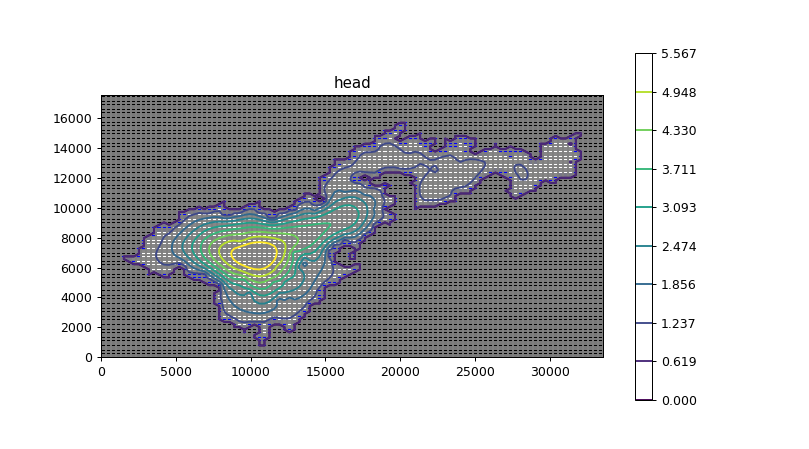

Water obtained is  -2091.3818359375 cubic m per day, with max drawdown of  3m


In [101]:
def optomizo(Q):
    model = Fin_Mod()
    model.run(Q)

    objval = Q

    observations = np.loadtxt('test_no_5.2.hob.out', skiprows=1, usecols=[0,1])
    residuals= []
    for idx, i in enumerate(observations):   
        r = observations[idx][1]-observations[idx][0]
        residuals.append(r)
    top_draw = max(residuals)
    
    rates = np.loadtxt('test_no_5.2.wel', skiprows=3, usecols=3)
    Sum_Q = sum(rates)

    if top_draw > 3:                 # this is where the maximum allwable drawdown is defined
        penalty = 100000* (top_draw + 1.0) ** 4               # this is where the penalty for exceeding maximum allwable drawdown is defined        
    else: 
        penalty = 0

    cost_ben = Sum_Q + penalty
    
    print("pumpting rate: %f, penalty : %f, objval: %f" % (Q, penalty, cost_ben))
    
    return cost_ben

# Use Nelder-Mead/Simplex method for this problem
results = opt.minimize(optomizo, x0=-1000.,method="Nelder-Mead",tol = 1.)

Good_Q = float(results['final_simplex'][0][0])
Fin_Mod().run(Good_Q)
Fin_Mod().plot()

print("Water obtained is  {} cubic m per day, with max drawdown of  3 m".format(Good_Q, ))